In [2]:
import os 
import matplotlib
import pandas  as pd 
import numpy as np
import seaborn as sns 

In [3]:
country_military_spending = pd.read_csv('military_spending_constant_2023.csv', sep = ',',    skiprows=5)
country_military_spending_2024 = country_military_spending[['Country','2024']]
country_military_spending_2024
us_spend = country_military_spending_2024[country_military_spending_2024['Country'] == 'United States of America'].copy()
other_countries_spend = country_military_spending_2024[country_military_spending_2024['Country'] != 'United States of America'].copy()
other_countries_spend = other_countries_spend.dropna()
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != 'xxx']
other_countries_spend = other_countries_spend[other_countries_spend['2024'] != '...']
other_countries_spend['2024'] = np.array(other_countries_spend['2024'], dtype=float)
### Change US Spend to Billions


In [91]:
import pandas as pd
import numpy as np

nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Finland", "Sweden", "Latvia", "Lithuania", "Croatia", "Albania",
    "Montenegro", "North Macedonia"
]

print(len(nato_countries))

# Load data
country_military_spending = pd.read_csv(
    'military_spending_constant_2023.csv',
    sep=',',
    skiprows=5
)

# Keep only relevant columns (2022 & 2024)
df = country_military_spending[['Country', '2022', '2024']].copy()

# Drop missing/invalid values
df = df.dropna()
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...')]
df = df[(df['2024'] != 'xxx') & (df['2024'] != '...')]

# Convert to numeric
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')

# Drop rows with NaN after conversion
df = df.dropna()

# Filter only NATO countries
df_nato = df[df['Country'].isin(nato_countries)].copy()

# Calculate percentage increase
df_nato['pct_increase'] = ((df_nato['2024'] - df_nato['2022']) / df_nato['2022']) * 100

# Sort by largest increase
df_nato_sorted = df_nato.sort_values(by='pct_increase', ascending=False)

# Show top NATO countries by % increase
print(df_nato_sorted[['Country', '2022', '2024', 'pct_increase']].head(10))


32
         Country      2022      2024  pct_increase
139       Poland 18,057.20 34,488.30         90.99
125      Albania    267.50    481.50         80.00
158      Denmark  5,801.20  9,781.60         68.61
166   Luxembourg    543.40    849.40         56.31
168  Netherlands 14,540.70 22,439.20         54.32
131      Estonia    917.50  1,392.70         51.79
172       Sweden  7,963.00 11,718.50         47.16
135       Latvia    958.10  1,404.80         46.62
129      Czechia  4,668.00  6,676.00         43.02
159      Finland  4,852.80  6,893.90         42.06


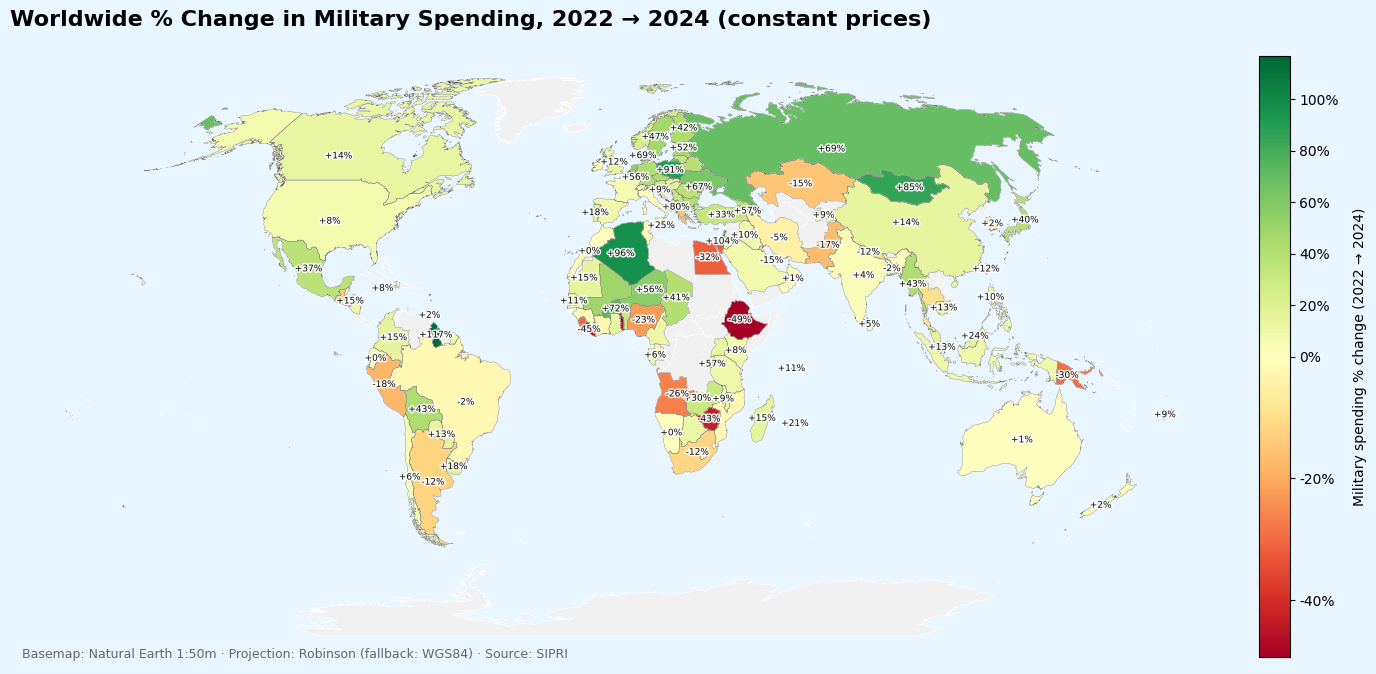

In [38]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patheffects as pe
from pathlib import Path
import zipfile, requests
from shapely.geometry import MultiPolygon

# --------------------------------------------------------
# B) Natural Earth Admin-0: download/cache
# --------------------------------------------------------
NE_URL = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
zip_path = cache_dir / "ne_50m_admin_0_countries.zip"
extract_dir = cache_dir / "ne_50m_admin_0_countries"

if not extract_dir.exists():
    if not zip_path.exists():
        r = requests.get(NE_URL, timeout=60)
        r.raise_for_status()
        zip_path.write_bytes(r.content)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

world = gpd.read_file(str(extract_dir / "ne_50m_admin_0_countries.shp"))

# --------------------------------------------------------
# C) Harmonize names
# --------------------------------------------------------
name_fix = {
    "Congo, DR": "Democratic Republic of the Congo",
    "Congo, Republic": "Republic of the Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Korea, South": "South Korea",
    "Korea, North": "North Korea",
    "Viet Nam": "Vietnam",
    "Lao PDR": "Laos",
    "Türkiye": "Turkey",
    "Eswatini": "Eswatini",
    "Czechia": "Czechia",
    "Russian Federation": "Russia",
    "United States of America": "United States of America",
    "Syrian Arab Republic": "Syria",
    "Iran": "Iran",
    "Bolivia": "Bolivia",
    "Tanzania": "Tanzania",
    "Moldova": "Moldova",
    "Venezuela": "Venezuela",
    "Micronesia, Fed. Sts.": "Federated States of Micronesia",
    "Timor Leste": "East Timor",
    "Palestine": "Palestine",
}

# --------------------------------------------------------
# A) INPUT DATA
# --------------------------------------------------------
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

# Clean + compute percent change
df = df.dropna(subset=['Country', '2022', '2024'])
df = df[(df['2022'] != 'xxx') & (df['2022'] != '...') & (df['2024'] != 'xxx') & (df['2024'] != '...')]
df['2022'] = pd.to_numeric(df['2022'], errors='coerce')
df['2024'] = pd.to_numeric(df['2024'], errors='coerce')
df = df.dropna(subset=['2022', '2024'])
df = df[df['2022'] > 0]

df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100
df = df.rename(columns={'Country': 'ne_name'})
df['ne_name_fixed'] = df['ne_name'].map(lambda x: name_fix.get(x, x))

# --------------------------------------------------------
# D) Merge % change onto world geometries
# --------------------------------------------------------
merge = world.merge(
    df[["ne_name_fixed", "pct_increase"]],
    left_on="NAME",
    right_on="ne_name_fixed",
    how="left"
)

# --------------------------------------------------------
# E) Projection (Robinson preferred)
# --------------------------------------------------------
target_crs = None
for candidate in ["ESRI:54030", "EPSG:4326"]:
    try:
        merge_proj = merge.to_crs(candidate)
        target_crs = candidate
        break
    except Exception:
        continue
if target_crs is None:
    merge_proj = merge  # fallback

# Helper: representative point inside largest polygon (for label placement)
def inside_label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    return geom.representative_point().coords[0]

# ---- Declutter: keep labels spaced apart ----
def select_spread(df_pts, min_dist):
    """
    Greedy selection: keep countries with the largest |pct_increase| first,
    then skip any whose label point lies within min_dist of a kept one.
    """
    keep_idx = []
    # Sort by absolute change (big movers get priority)
    ordered = df_pts.reindex(df_pts['pct_increase'].abs().sort_values(ascending=False).index)
    xs = ordered['label_x'].to_numpy()
    ys = ordered['label_y'].to_numpy()
    for i, idx in enumerate(ordered.index):
        x, y = xs[i], ys[i]
        too_close = False
        for j in keep_idx:
            dx = x - ordered.loc[j, 'label_x']
            dy = y - ordered.loc[j, 'label_y']
            if (dx*dx + dy*dy) ** 0.5 < min_dist:
                too_close = True
                break
        if not too_close:
            keep_idx.append(idx)
    return ordered.loc[keep_idx]

# Choose a sensible spacing threshold based on CRS units
if target_crs == "ESRI:54030":
    # Robinson uses meters; ~600 km spacing helps declutter Europe/SEA/West Africa
    min_dist = 600_000
else:
    # Degrees (WGS84); ~5 degrees
    min_dist = 5.0

# --------------------------------------------------------
# F) Plot — diverging map + decluttered annotations
# --------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 8), facecolor="#e9f6ff")  # very light blue background

# Base countries (no data)
merge_proj.plot(ax=ax, facecolor="#f0f0f0", edgecolor="white", linewidth=0.4, zorder=1)

# Countries with data
countries = merge_proj.dropna(subset=["pct_increase"]).copy()

# Diverging colormap centered at 0 (red = decrease, green = increase)
vmin = countries["pct_increase"].min()
vmax = countries["pct_increase"].max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = plt.cm.RdYlGn  # red low, green high

countries.plot(
    ax=ax,
    column="pct_increase",
    cmap=cmap,
    linewidth=0.4,
    edgecolor="white",
    norm=norm,
    zorder=2
)

# Thin boundaries
countries.boundary.plot(ax=ax, linewidth=0.2, edgecolor="#444444", zorder=3)

# ---- Prepare label points and declutter ----
countries["label_x"], countries["label_y"] = zip(*countries.geometry.apply(inside_label_point))
labels = select_spread(countries[["NAME", "pct_increase", "label_x", "label_y"]].copy(), min_dist=min_dist)

# ---- Annotations (signed percentages) ----
for _, r in labels.iterrows():
    plt.text(
        r["label_x"], r["label_y"],
        f"{r['pct_increase']:+.0f}%",
        ha="center", va="center",
        fontsize=6.5, color="#111111",
        zorder=4, clip_on=True,
        path_effects=[pe.withStroke(linewidth=2.2, foreground="white", alpha=0.9)]
    )

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.78, pad=0.02)
cbar.set_label("Military spending % change (2022 → 2024)", rotation=90, labelpad=10)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

# Title & caption
ax.set_title("Worldwide % Change in Military Spending, 2022 → 2024 (constant prices)",
             fontsize=16, loc="left", weight="bold")
ax.text(0.01, 0.01,
        "Basemap: Natural Earth 1:50m · Projection: Robinson (fallback: WGS84) · Source: SIPRI",
        transform=ax.transAxes, fontsize=9, color="#666666")

ax.set_axis_off()
ax.set_facecolor("#e9f6ff")
plt.tight_layout()
plt.savefig("world_increase_military_spending.png", dpi=600, bbox_inches="tight")
plt.show()


In [72]:

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile, requests
from shapely.geometry import box
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

for col in ['2022', '2024']:
    df = df[df[col].notna()]
    df = df[(df[col] != 'xxx') & (df[col] != '...')]
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['2022','2024'])

df = df[df['Country'].isin(nato_countries)].copy()
df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100

# Fix name mismatches for Natural Earth
name_fix = {"Czech Republic": "Czechia"}
df['ne_name'] = df['Country'].replace(name_fix)

# -------------------------
# 2) Natural Earth Admin-0 Countries (download/cache once)
# -------------------------
ADMIN0_URL = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
admin_zip = cache_dir / "ne_110m_admin_0_countries.zip"
admin_dir = cache_dir / "ne_110m_admin_0_countries"

if not admin_dir.exists():
    if not admin_zip.exists():
        r = requests.get(ADMIN0_URL, timeout=60)
        r.raise_for_status()
        admin_zip.write_bytes(r.content)
    with zipfile.ZipFile(admin_zip, 'r') as zf:
        zf.extractall(admin_dir)

admin0 = gpd.read_file(str(admin_dir / "ne_110m_admin_0_countries.shp"))

# -------------------------
# 3) Keep Europe only (strict) and clip to mainland bbox
#    bbox (lon/lat): roughly mainland Europe; excludes Iceland/Canaries/Azores
# -------------------------
europe = admin0[admin0['CONTINENT'] == 'Europe'].copy()

# Mainland Europe bounding box
# tweak if you want a little more/less margin
bbox = box(-11, 34, 32, 72)   # (min_lon, min_lat, max_lon, max_lat)
europe_mainland = gpd.clip(europe, bbox)

# -------------------------
# 4) Merge your % change onto the polygons
# -------------------------
merge = europe_mainland.merge(
    df[['ne_name','pct_increase']],
    left_on='NAME',
    right_on='ne_name',
    how='left'
)

# -------------------------
# 5) Plot — Europe (mainland) only, yellow → dark red
# -------------------------


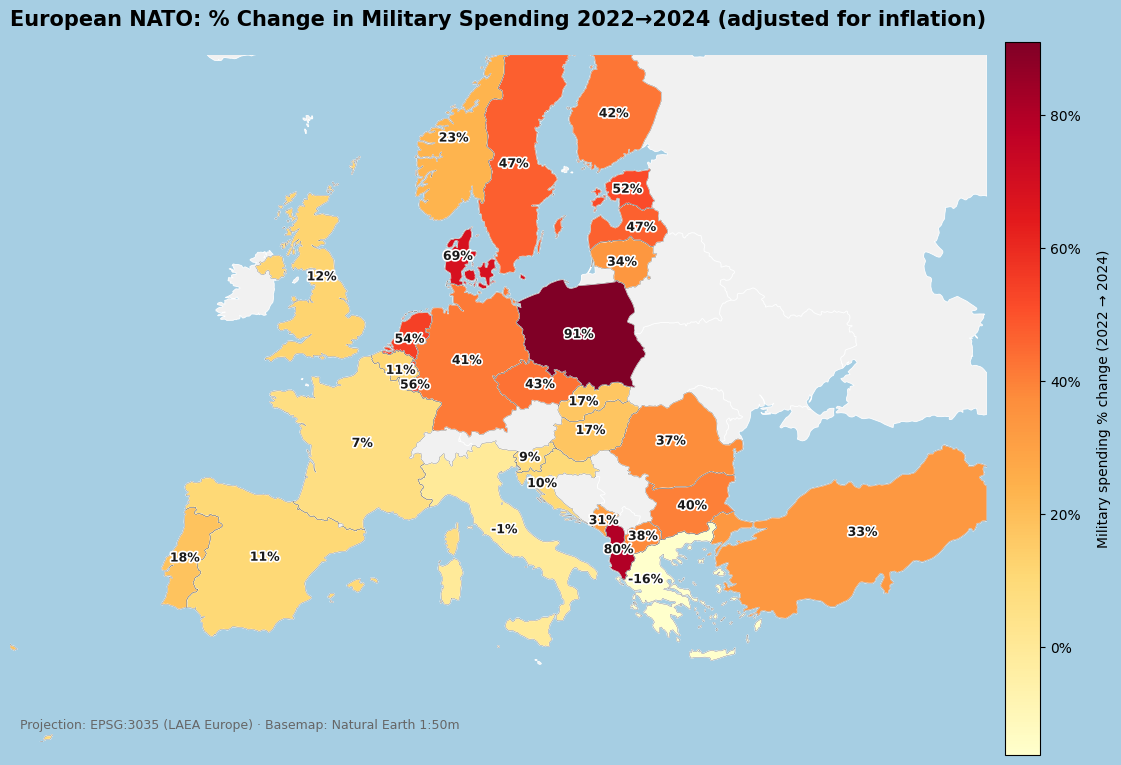

In [89]:
# -*- coding: utf-8 -*-
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from pathlib import Path
import zipfile, requests
from shapely.geometry import box, MultiPolygon

# ------------------------------------------
# Example data — replace with your own
# ------------------------------------------
df = pd.read_csv('military_spending_constant_2023.csv', sep=',', skiprows=5)
df = df[['Country', '2022', '2024']].copy()

for col in ['2022', '2024']:
    df = df[df[col].notna()]
    df = df[(df[col] != 'xxx') & (df[col] != '...')]
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['2022','2024'])

df = df[df['Country'].isin(nato_countries)].copy()
df['pct_increase'] = (df['2024'] - df['2022']) / df['2022'] * 100

# Fix name mismatches for Natural Earth
name_fix = { "Czechia":"Czech Republic",     "Türkiye": "Turkey",}
df['ne_name'] = df['Country'].replace(name_fix)
#merge = europe.merge(df_nato_sorted[['ne_name','pct_increase']], left_on='NAME', right_on='ne_name', how='left')
#df = merge.copy()

# ------------------------------------------
# Load Natural Earth Admin-0 Countries (50m)
# ------------------------------------------
NE_URL = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"
cache_dir = Path("data/cache")
cache_dir.mkdir(parents=True, exist_ok=True)
zip_path = cache_dir / "ne_50m_admin_0_countries.zip"
extract_dir = cache_dir / "ne_50m_admin_0_countries"

if not extract_dir.exists():
    if not zip_path.exists():
        r = requests.get(NE_URL, timeout=60)
        r.raise_for_status()
        zip_path.write_bytes(r.content)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

world = gpd.read_file(str(extract_dir / "ne_50m_admin_0_countries.shp"))

# ------------------------------------------
# Include Europe + Türkiye (ADM0_A3 == "TUR")
# ------------------------------------------
europe = world[(world["CONTINENT"] == "Europe") | (world["ADM0_A3"] == "TUR")].copy()

# normalize name field
name_col = "NAME_EN" if "NAME_EN" in europe.columns else "NAME"
europe["NAME_JOIN"] = europe[name_col].fillna(europe["NAME"])

# fix df names to match NE
df["ne_name"] = df["ne_name"].replace({"Türkiye": "Turkey", "Türkiye (Turkey)": "Turkey"})

# ------------------------------------------
# Project and merge data
# ------------------------------------------
europe_3035 = europe.to_crs(3035)
merge = europe_3035.merge(df, left_on="NAME_JOIN", right_on="ne_name", how="left")

# ------------------------------------------
# Set a custom bounding box to show all Europe + Türkiye
# ------------------------------------------
# These values work well in EPSG:3035
minx, miny, maxx, maxy = 1800000, 1000000, 7200000, 4800000
clip_box = gpd.GeoDataFrame(geometry=[box(minx, miny, maxx, maxy)], crs=merge.crs)

europe_outline = gpd.overlay(europe_3035, clip_box, how="intersection")
merge = gpd.overlay(merge, clip_box, how="intersection")

# ------------------------------------------
# Helper for label placement
# ------------------------------------------
def inside_label_point(geom):
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda g: g.area)
    pt = geom.representative_point()
    return (pt.x, pt.y)

labels = merge.dropna(subset=["pct_increase"]).copy()
labels["label_x"], labels["label_y"] = zip(*labels.geometry.apply(inside_label_point))

# ------------------------------------------
# Plot
# ------------------------------------------
plt.rcParams.update({"figure.facecolor": "#a6cee3"})
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_facecolor("#a6cee3")

# Outline
europe_outline.plot(ax=ax, facecolor="#f1f1f1", edgecolor="white", linewidth=0.6, zorder=1)

# Choropleth
countries = merge.dropna(subset=["pct_increase"])
chor = countries.plot(
    ax=ax,
    column="pct_increase",
    cmap="YlOrRd",
    linewidth=0.7,
    edgecolor="white",
    zorder=2
)
countries.boundary.plot(ax=ax, linewidth=0.2, edgecolor="#444444", zorder=3)

# Labels
for _, r in labels.iterrows():
    ax.text(
        r["label_x"], r["label_y"],
        f"{r['pct_increase']:.0f}%",
        ha="center", va="center",
        fontsize=9, fontweight="bold", color="#1a1a1a",
        path_effects=[pe.withStroke(linewidth=2.4, foreground="white")],
        zorder=4
    )

# Colorbar
import matplotlib as mpl
sm = plt.cm.ScalarMappable(
    norm=mpl.colors.Normalize(vmin=countries["pct_increase"].min(),
                              vmax=countries["pct_increase"].max()),
    cmap="YlOrRd"
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, shrink=0.82, pad=0.015)
cbar.set_label("Military spending % change (2022 → 2024)", rotation=90, labelpad=12)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v)}%"))

# Title + caption
ax.set_title("European NATO: % Change in Military Spending 2022→2024 (adjusted for inflation)",
             fontsize=15, pad=10, loc="left", weight='bold')
ax.text(0.01, 0.02,
        "Projection: EPSG:3035 (LAEA Europe) · Basemap: Natural Earth 1:50m",
        transform=ax.transAxes, fontsize=9, color="#666666")

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("europe_turkiye_military_spending_2.png", dpi=1000)
plt.show()


In [105]:
# ---- Plot: US vs stacked "Next N countries" ----
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })

def economist_axis_touches(ax):
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    fig.text(0.0, y_offset, text, ha="left", va="bottom", fontsize=10, color="#5a5a5a")

/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)
/var/folders/cw/m3xj051j4qdfbhhykf_lxz6r0000gp/T/ipykernel_95470/477789150.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  us_val = float(us_spend[year_label])
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 

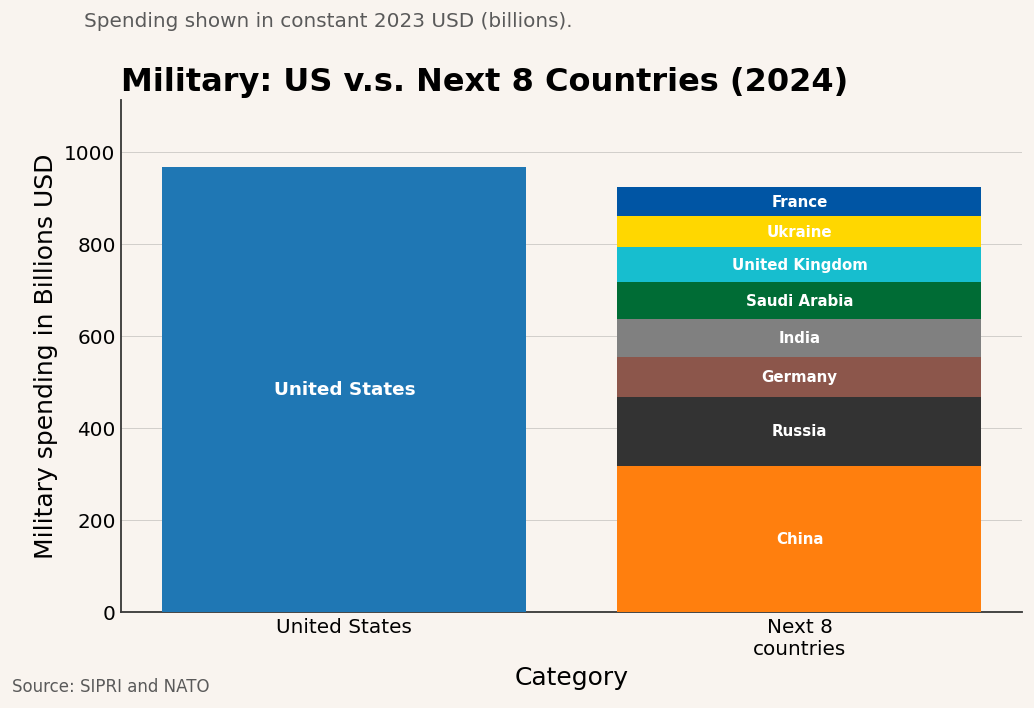

In [6]:
# ---- Plot: US vs stacked "Next N countries" ----
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -----------------------
# Economist / FT-like Matplotlib style
# -----------------------
def set_pubstyle_econ_ft(base_fontsize=12):
    mpl.rcParams.update({
        # Typography
        "font.family": ["IBM Plex Sans", "Source Sans 3", "Lato", "DejaVu Sans"],
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize * 1.6,
        "axes.labelsize": base_fontsize * 1.25,
        "legend.fontsize": base_fontsize * 0.95,
        "xtick.labelsize": base_fontsize * 1.0,
        "ytick.labelsize": base_fontsize * 1.0,

        # Lines & grid
        "axes.grid": True,
        "grid.linestyle": "-",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "axes.axisbelow": True,

        # Spines
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Figure
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",

        # Legend
        "legend.frameon": False,
        "legend.loc": "upper left",

        # Tick params
        "xtick.major.size": 0,
        "ytick.major.size": 0,
        "xtick.minor.size": 0,
        "ytick.minor.size": 0,
    })

def economist_axis_touches(ax):
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)
    ax.spines["left"].set_color("#3a3a3a")
    ax.spines["bottom"].set_color("#3a3a3a")
    ax.grid(axis="y", color="#8a8a8a")
    ax.grid(axis="x", visible=False)

def add_caption(fig, text, y_offset=0.02):
    fig.text(0.0, y_offset, text, ha="left", va="bottom", fontsize=10, color="#5a5a5a")

# -----------------------------------------
# Example data (replace with your real data)
# -----------------------------------------
year_label = "2024"  # keep consistent with title
#us_spend = {year_label: 916_000}  # millions, example only

#needed_countries = ["China", "Russia", "India", "UK", "Germany"]
#needed_spends =    [296_000, 109_000,  87_000,  74_000,   66_000]  # millions, example only

xtick_step = 1  # not crucial here, but kept in case you reuse

# -----------------------
# Build the plot
# -----------------------
set_pubstyle_econ_ft(base_fontsize=12)

fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")
ax = plt.gca()
ax.set_facecolor("#f9f4ef")

economist_axis_touches(ax)
ax.set_ylim(0, max(float(us_spend['2024']), sum(needed_spends)) * 1.15)

# Titles & labels
ax.set_xlabel("Category")
ax.set_ylabel("Military spending in Billions USD")
ax.set_title(f"Military: US v.s. Next 8 Countries ({year_label})", loc="left", fontweight="bold")

subtitle = "Spending shown in constant 2023 USD (billions)."

fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

# X axis ticks (no real 'years' here, so use a neutral locator)
ax.xaxis.set_major_locator(mticker.FixedLocator([0, 1]))
country_colors = {
    "Russia": "#333333",                  # near-black
    "China": "#FF7F0E",                   # orange
    "United States of America": "#1f77b4",# strong blue
    "United Kingdom": "#17becf",          # cyan / teal
    "France": "#0055A4",                  # deep flag blue
    "Ukraine": "#FFD700",                 # golden yellow
    "Germany": "#8c564b",                 # brownish gray
    "Saudi Arabia": "#006C35"             # emerald green
}



# Bars
x_positions = [0, 1]
us_name = "United States"

us_val = float(us_spend[year_label])
us_bar = ax.bar(x_positions[0], us_val, zorder=3, color="#1F77B4")  # optional color
# Put label in the middle of the bar
ax.text(
    x_positions[0], us_val/2, us_name,
    ha="center", va="center", fontsize=11, color="white", fontweight="bold"
)

bottom = 0.0
for cname, cval in zip(needed_countries, needed_spends):
    bar = ax.bar(
        x_positions[1], cval, bottom=bottom, zorder=3,
        color=country_colors.get(cname, "gray")  # fallback if not mapped
    )
    
    # Position text in the middle of the segment
    ax.text(
        x_positions[1], bottom + cval/2, cname,
        ha="center", va="center", fontsize=9, color="white", fontweight="bold"
    )
    
    bottom += cval

# X tick labels (two-line label for the right bar)
ax.set_xticks(x_positions)
ax.set_xticklabels([us_name, f"Next {len(needed_countries)}\ncountries"])

# Legend (list stacked countries clearly)
#ax.legend(title="Stacked countries", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)

# Caption/source (optional)
add_caption(fig, "Source: SIPRI and NATO")

plt.tight_layout(rect=[0, 0, 0.86, 0.95])  # leave room for the outside legend & suptitle
plt.savefig(fname = 'total_military_spending_comparison.png',dpi = 1000)

plt.show()


In [109]:

# NATO members (as listed in your dataset — adjust names if needed)
nato_countries = [
    "United States of America", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Turkey", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czech Republic",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# List of European NATO countries (exclude US & Canada)
# European NATO members
european_nato = [
    "Albania",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Czechia",
    "Denmark",
    "Estonia",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "United Kingdom",
    "Türkiye"   # transcontinental but NATO member, listed as "Türkiye" in SIPRI
]



# Canada
canada_nato = ["Canada"]

# United States
us_nato = ["United States of America"]


# Load dataset
country_military_spending = pd.read_csv(
    "military_expenditures_in_shared_of_gdp.tsv",
    sep="\t",
    skiprows=5
)

# Keep only NATO members
nato_spending = country_military_spending[
    country_military_spending["Country"].isin(nato_countries)
]

us_military_spending = country_military_spending[
    country_military_spending["Country"].isin(us_nato)
]


# Reshape to long format
nato_long = nato_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Keep only numeric years
nato_long = nato_long[nato_long["Year"].str.isnumeric()]
nato_long["Year"] = nato_long["Year"].astype(int)
nato_long = nato_long[nato_long["Spending"] != "..."]

nato_long["Spending"] = (
    nato_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
nato_long["Spending"] = nato_long["Spending"].astype(float)
europe_long = nato_long[nato_long["Country"].isin(european_nato)]



us_long = us_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Convert Year to int (if they are strings)
us_long = us_long[us_long["Year"].str.isnumeric()]

us_long["Year"] = us_long["Year"].astype(int)
us_long["Spending"] = (
    us_long["Spending"]
    .replace(r"%", "", regex=True)
    .astype(float)
)
us_long["Spending"] = us_long["Spending"].astype(float)

# Build a long-form dataframe for ALL countries (no NATO filter)



all_long = country_military_spending.melt(
    id_vars=["Country"],
    var_name="Year",
    value_name="Spending"
)

# Clean it the same way
all_long = all_long[all_long["Year"].astype(str).str.isnumeric()].copy()
all_long["Year"] = all_long["Year"].astype(int)

all_long = all_long[~all_long["Spending"].isin(["...", ". ."])].copy()
all_long["Spending"] = (
    all_long["Spending"].astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
)
all_long = all_long[pd.to_numeric(all_long["Spending"], errors="coerce").notna()].copy()
all_long["Spending"] = all_long["Spending"].astype(float)

# Russia & China series (averages per year in case of duplicates)
russia_avg = (
    all_long[all_long["Country"] == "Russia"]
    .groupby("Year")["Spending"].mean().reset_index()
)
china_avg = (
    all_long[all_long["Country"] == "China"]
    .groupby("Year")["Spending"].mean().reset_index()
)






findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

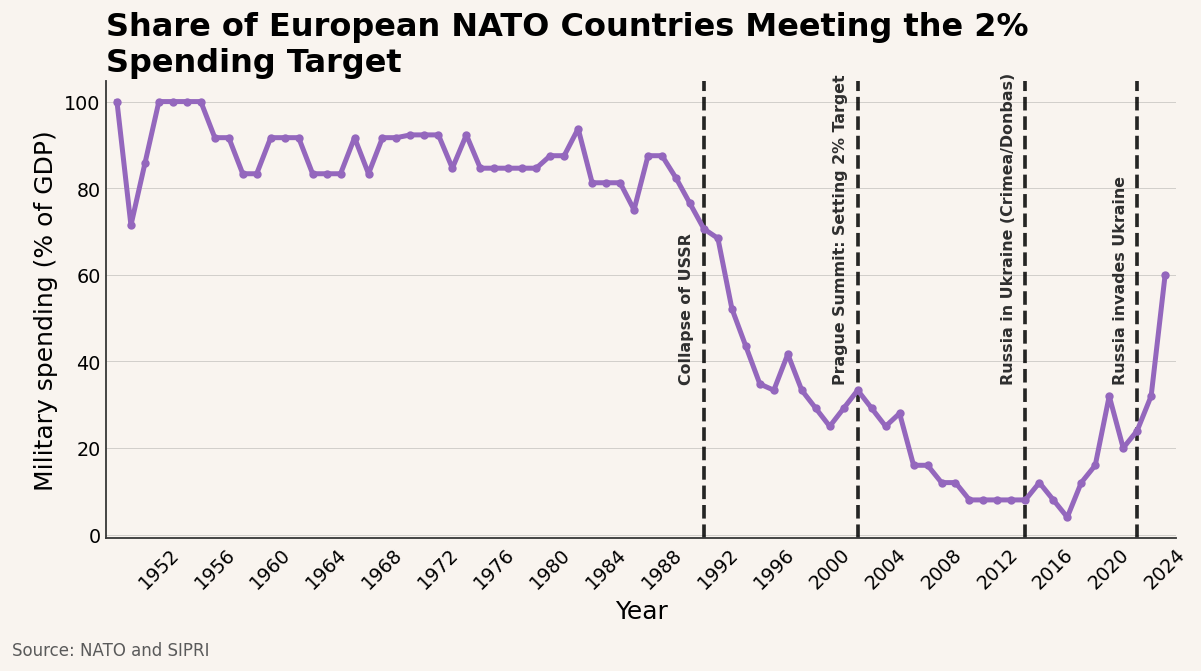

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to European NATO countries
eu = nato_long[nato_long["Country"].isin(european_nato)].copy()

# For each year: percentage of countries with Spending >= 2 (only among countries with data that year)
eu_yearly = (
    eu.groupby("Year")["Spending"]
      .agg(total=lambda s: s.notna().sum(),
           hits=lambda s: (s >= 2).sum())
      .reset_index()
)
eu_yearly["pct_above_2"] = eu_yearly["hits"] / eu_yearly["total"] * 100

# Plot
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area
set_pubstyle_econ_ft(base_fontsize=12)

ax.tick_params(axis="both", which="major", labelsize=14)
economist_axis_touches(ax)
ax.plot(
    eu_yearly["Year"], eu_yearly["pct_above_2"],
    linewidth=3, marker="o", markersize=4, color="#9467BD",  # purple (colorblind-friendly)
    label="European NATO at ≥ 2%"
)

events = [
    (1991, "Collapse of USSR"),
    (2002, "Prague Summit: Setting 2% Target"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine")
]


# Draw the vertical lines
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Place labels *inside* the plot, close to bottom
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)   # 10% above bottom

for x, label in events:
    ax.text(
        x - 1.75, label_y + 25,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#2f2f2f", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )
# Formatting
#ax.title("Share of European NATO Countries Meeting the 2% Guideline", fontsize=18, fontweight="bold")


subtitle = "Spending shown in constant 2023 USD (billions)."


ax.set_title(f"Share of European NATO Countries Meeting the 2% \nSpending Target", loc="left", fontweight="bold")
#fig.suptitle(subtitle, x=0.06, y=0.94, ha="left", fontsize=12, color="#5a5a5a")

ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")



# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: NATO and SIPRI")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'european_countries_meeting_2_percent_target.png',dpi = 1000)

plt.show()

In [111]:
import pandas as pd

# Load the CSV
file_path = "social_spending_ssocx.csv"
df = pd.read_csv(file_path)

# Select and rename relevant columns
df_clean = df[["Reference area", "TIME_PERIOD", "OBS_VALUE"]].rename(
    columns={
        "Reference area": "Country",
        "TIME_PERIOD": "Year",
        "OBS_VALUE": "Public social spending (% of GDP)"
    }
)

# Convert year to integer
df_clean["Year"] = df_clean["Year"].astype(int)

# Convert spending to numeric
df_clean["Public social spending (% of GDP)"] = pd.to_numeric(df_clean["Public social spending (% of GDP)"], errors="coerce")

print(df_clean.head())
df_clean = df_clean.dropna()
df_clean

   Country  Year  Public social spending (% of GDP)
0  Romania  1980                                NaN
1  Romania  1981                                NaN
2  Romania  1982                                NaN
3  Romania  1983                                NaN
4  Romania  1984                                NaN


,Country,Year,Public social spending (% of GDP)
91,Norway,2006,19.40
92,Norway,2007,19.52
93,Norway,2008,19.17
94,Norway,2009,22.41
95,Norway,2010,22.00
...,...,...,...
1901,Costa Rica,2018,12.43
1902,Costa Rica,2019,12.33
1903,Costa Rica,2020,14.37
1904,Costa Rica,2021,12.70


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

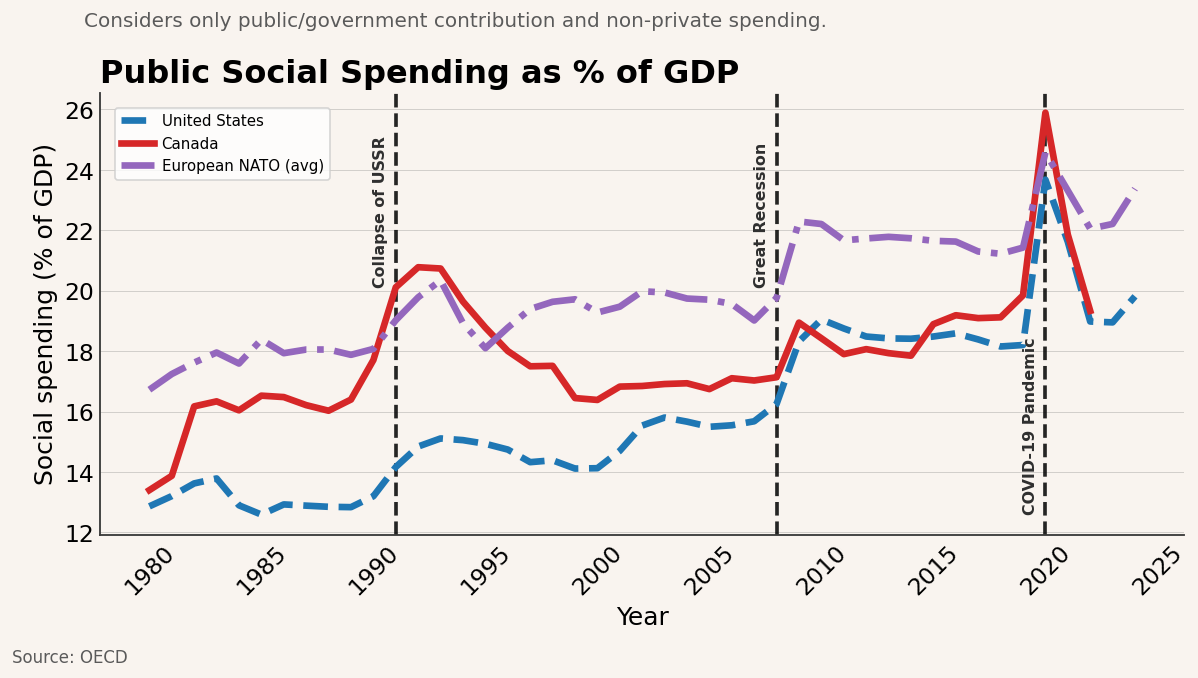

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Your cleaned DataFrame
df = df_clean

# Full NATO list
nato_countries = [
    "United States", "Canada", "United Kingdom", "France", "Germany",
    "Italy", "Spain", "Portugal", "Greece", "Türkiye", "Belgium", "Netherlands",
    "Luxembourg", "Norway", "Denmark", "Iceland", "Poland", "Czechia",
    "Hungary", "Slovakia", "Slovenia", "Romania", "Bulgaria", "Estonia",
    "Latvia", "Lithuania", "Croatia", "Albania", "Montenegro", "North Macedonia"
]

# Filter for NATO countries and Year >= 1949
df_nato = df[df["Country"].isin(nato_countries)].copy()
df_nato = df_nato[df_nato["Year"] >= 1949]

# Split categories
us = df_nato[df_nato["Country"] == "United States"].sort_values(by="Year")
canada = df_nato[df_nato["Country"] == "Canada"].sort_values(by="Year")

# European NATO countries (exclude US, Canada)
europe = df_nato[~df_nato["Country"].isin(["United States", "Canada"])].sort_values(by="Year")

# Compute average social spending for Europe
europe_avg = europe.groupby("Year")["Public social spending (% of GDP)"].mean().reset_index()

# --- Plot setup ---
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")
ax = plt.gca()
ax.set_facecolor("#f9f4ef")
set_pubstyle_econ_ft(base_fontsize=12)
economist_axis_touches(ax)

ax.tick_params(axis="both", which="major", labelsize=14)

# Historical events
events = [
    (1991, "Collapse of USSR"),
    (2008, "Great Recession"),
    (2020, "COVID-19 Pandemic"),
]

# Draw vertical lines for key events
for x, _ in events:
    ax.axvline(x=x, color="black", linestyle="--", linewidth=2.2, alpha=0.85, zorder=1)

# Label events near the bottom of the plot
ymin, ymax = ax.get_ylim()
label_y = ymin + 0.1 * (ymax - ymin)

for x, label in events:
    y_offset = 20 if x != 2020 else 12.5
    ax.text(
        x - 1., label_y + y_offset, label,
        rotation=90, fontsize=9.5, va="bottom", ha="left",
        color="#2f2f2f", weight='bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )

# Plot the lines
ax.plot(us["Year"], us["Public social spending (% of GDP)"],
        label="United States", color="#1F77B4", linestyle="--", linewidth=4)
ax.plot(canada["Year"], canada["Public social spending (% of GDP)"],
        label="Canada", color="#D62728", linewidth=4)
ax.plot(europe_avg["Year"], europe_avg["Public social spending (% of GDP)"],
        label="European NATO (avg)", color="#9467BD", linewidth=4, linestyle="-.")

# Titles and labels
ax.set_title("Public Social Spending as % of GDP", loc="left", fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Social spending (% of GDP)")

subtitle = "Considers only public/government contribution and non-private spending."
fig.suptitle(subtitle, x=0.06, y=0.90, ha="left", fontsize=12, color="#5a5a5a")

# Legend formatting
leg = ax.legend(
    ncol=1, frameon=True, facecolor="white", edgecolor="#cccccc",
    handlelength=2.2, handletextpad=0.5, borderaxespad=1.0,
    loc="upper left", fontsize=9
)

# --- Only show full integer years on x-axis ---
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
ax.tick_params(axis="x", rotation=45)

# Caption / source note
add_caption(fig, "Source: OECD")

# Layout and save
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig('nato_countries_social_spending.png', dpi=1000)
plt.show()


findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sans' not found.
findfont: Font family 'Source Sans 3' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'IBM Plex Sa

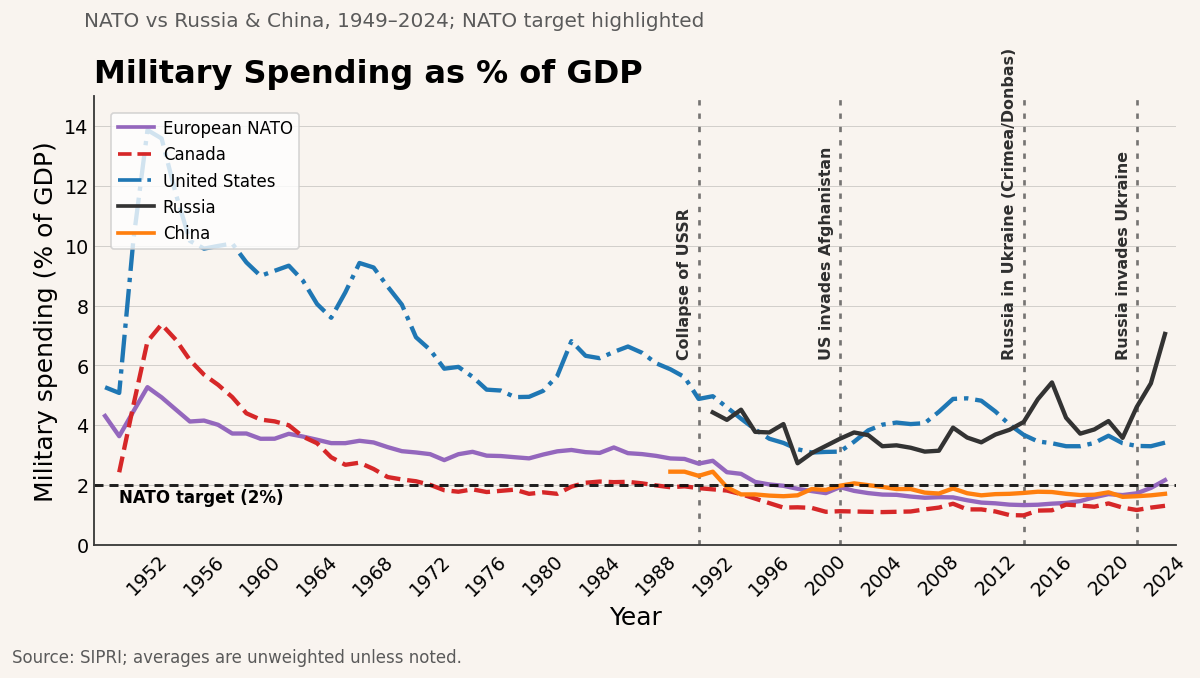

In [118]:
import matplotlib as mpl
import matplotlib.pyplot as plt

europe_grouped = (
    nato_long[nato_long["Country"].isin(european_nato)]
    .groupby(["Year"])["Spending"]
)

europe_mean = europe_grouped.mean()
europe_std = europe_grouped.std()


# Canada
canada_avg = (
    nato_long[nato_long["Country"].isin(canada_nato)]
    .groupby("Year")["Spending"]
    .mean()
    .reset_index()
)

# United States
us_avg = (
    nato_long[nato_long["Country"].isin(us_nato)]
    .groupby("Year")["Spending"]
    .mean()
    .reset_index()
)

# -----------------------
# Plot with Russia & China (colorblind-friendly palette)
# -----------------------
fig = plt.figure(figsize=(10, 6.2), facecolor="#f9f4ef")  # very light tan
ax = plt.gca()
ax.set_facecolor("#f9f4ef")  # match background for the plotting area


# European NATO average (purple)
ax.plot(
    europe_mean.index, europe_mean.values,
    linewidth=2.6, color="#9467BD", label="European NATO"
)

# Canada (red, dashed)
ax.plot(
    canada_avg["Year"], canada_avg["Spending"],
    linewidth=2.6, linestyle="--", color="#D62728", label="Canada"
)

# United States (blue, dash-dot)
ax.plot(
    us_avg["Year"], us_avg["Spending"],
    linewidth=2.6, linestyle="-.", color="#1F77B4", label="United States"
)

# Russia (near-black)
ax.plot(
    russia_avg["Year"], russia_avg["Spending"],
    linewidth=2.6, color="#333333", label="Russia"
)

# China (orange)
ax.plot(
    china_avg["Year"], china_avg["Spending"],
    linewidth=2.6, color="#FF7F0E", label="China"
)

ax.text(
        1950, 1.3,
        "NATO target (2%)",
        fontsize=10,
        va="bottom", ha="left",
        color="#000000", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )


# NATO guideline
ax.axhline(2, color="#0c0c0c", linestyle=(0, (3, 2)), linewidth=1.8, alpha=0.9)

# Event markers (thin, tidy, labeled)
events = [
    (1991, "Collapse of USSR"),
    (2001, "US invades Afghanistan"),
    (2014, "Russia in Ukraine (Crimea/Donbas)"),
    (2022, "Russia invades Ukraine"),
]

for x, _ in events:
    ax.axvline(x=x, color="#2f2f2f", linestyle=(0, (2, 3)), linewidth=1.6, alpha=0.65, zorder=1)

ymin, ymax = ax.get_ylim()
label_y = ymin + 0.06 * (ymax - ymin)   # low, but inside the chart

for x, label in events:
    ax.text(
        x - 1.5, label_y + 5,
        label,
        rotation=90,
        fontsize=9.5,
        va="bottom", ha="left",
        color="#2f2f2f", weight = 'bold',
        bbox=dict(facecolor="none", edgecolor="none", pad=2.2),
        zorder=5
    )

# Axes formatting
economist_axis_touches(ax)
ax.set_ylim(0, 15)
ax.set_xlabel("Year")
ax.set_ylabel("Military spending (% of GDP)")

# Title + subtitle (FT/Economist style: bold title, lighter subtitle)
title = "Military Spending as % of GDP"
subtitle = "NATO vs Russia & China, 1949–2024; NATO target highlighted"
ax.set_title(title, loc="left", fontweight="bold", pad=8)
fig.suptitle(subtitle, x=0.06, y=0.90, ha="left", fontsize=12, color="#5a5a5a")

# Legend (with opaque background for clarity)
leg = ax.legend(
    ncol=1,
    frameon=True,        # show background panel
    facecolor="white",   # solid white background
    edgecolor="#cccccc", # subtle gray border
    handlelength=2.2,
    handletextpad=0.5,
    borderaxespad=1.0,
    loc="upper left",
    fontsize=10
)

# Standardize line thickness inside legend
for line in leg.get_lines():
    line.set_linewidth(2.2)

# Ticks: nice integer years if your x is datetime/int; adjust as needed
ax.margins(x=0.01)
ax.tick_params(axis="both", which="major", labelsize=11.5)

# Caption / source note
add_caption(fig, "Source: SIPRI; averages are unweighted unless noted.")
import matplotlib.ticker as mticker

# Get current number of ticks
import matplotlib.ticker as mticker

# Get how many ticks you currently have
num_ticks = len(ax.get_xticks())

# Request roughly double
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=num_ticks * 2))
ax.tick_params(axis="x", rotation=45)   # rotate all x tick labels
plt.tight_layout(rect=[0, 0.04, 1, 0.92])
plt.savefig(fname = 'countries_military_spending.png',dpi = 1000)

plt.show()
